In [1]:
import os
os.environ["TAVILY_API_KEY"] = "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"

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

In [3]:
class BasicChatBot(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

C:\Users\Acer\AppData\Local\Temp\ipykernel_19056\4175704960.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


In [5]:
groq_api = "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"

llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api)

llm_with_tools = llm.bind_tools(tools=tools)

In [6]:
def chatbot(state: BasicChatBot):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

tool_node = ToolNode(tools=tools)


def tools_router(state: BasicChatBot):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END

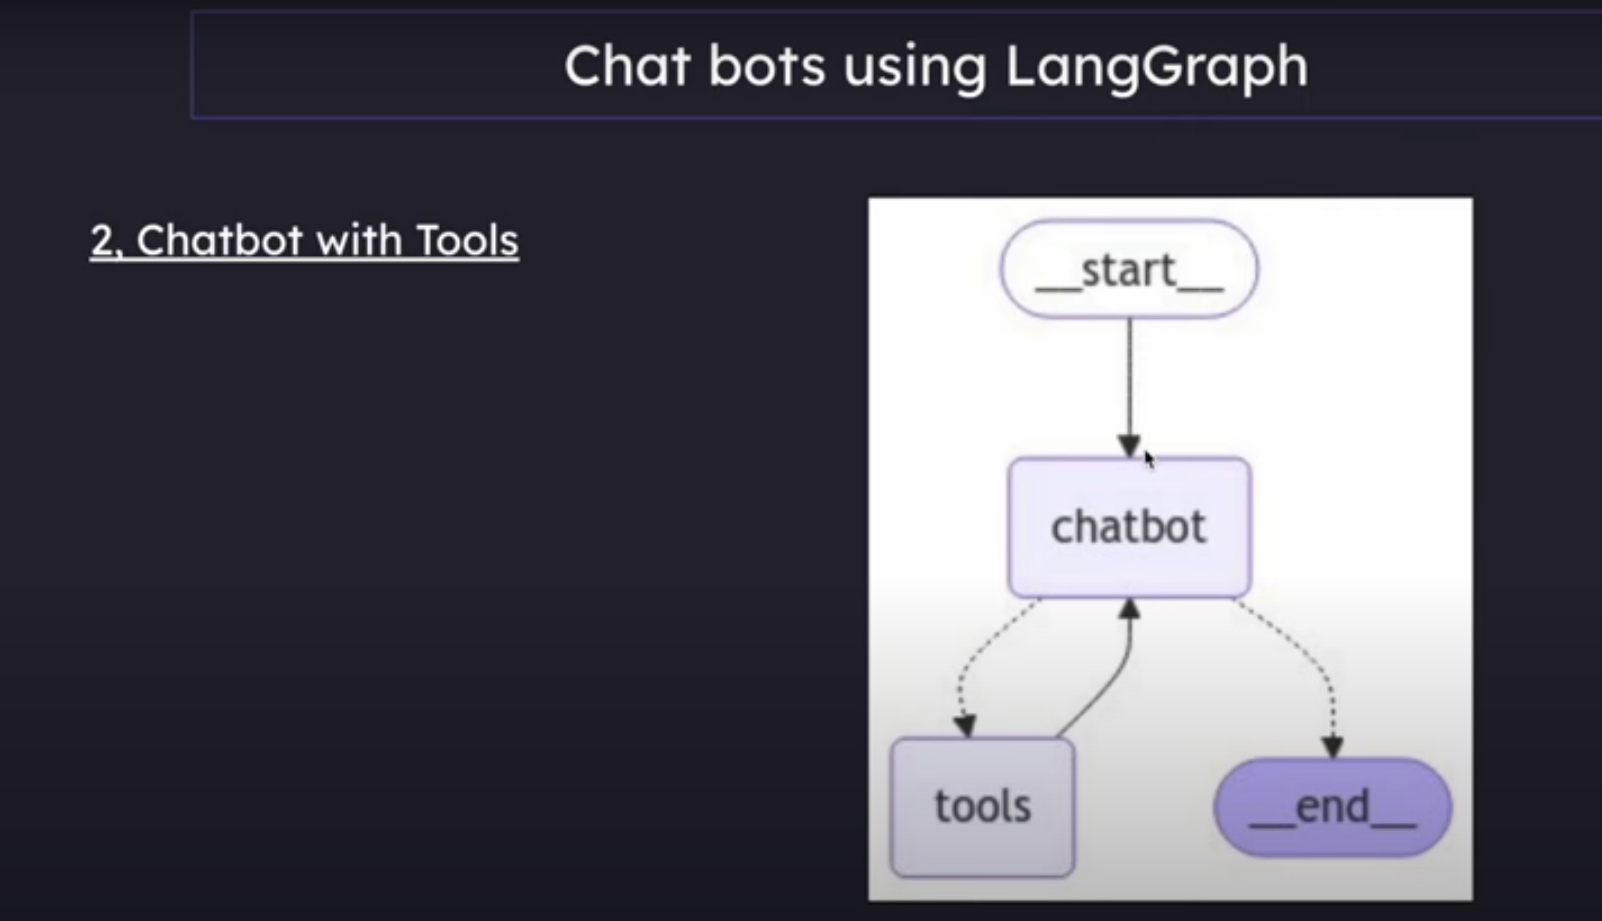

In [7]:

graph = StateGraph(BasicChatBot)

graph.add_node("chatbot", chatbot)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", tools_router)
graph.add_edge("tool_node", "chatbot")

app = graph.compile()


In [8]:

while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        })

        print(result)

{'messages': [HumanMessage(content='hi can u tell me weather of tommorw at vallabhapuram', additional_kwargs={}, response_metadata={}, id='9fdc8eef-9554-4765-b70e-9d8ad55b6ce8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gnyq4zsa1', 'function': {'arguments': '{"query":"Vallabhapuram weather tomorrow"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 296, 'total_tokens': 321, 'completion_time': 0.035190232, 'prompt_time': 0.017519317, 'queue_time': 0.048382483, 'total_time': 0.052709549}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4f1ed360-2d6c-4d84-b638-4e6203a12072-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Vallabhapuram weather tomorrow'}, 'id': 'gnyq4zsa1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 296, 'output_tokens': 25, 'total_token